# RANSAC with Hessian Affine SIFT descriptor

In [41]:
import cv2
import numpy as np
from skimage.measure import ransac as _ransac
from skimage.transform import AffineTransform
import matplotlib.pyplot as plt


def get_matches(des1, des2, method='BRUTE_FORCE', is_binary_descriptor=True):
    # create BFMatcher object    
    if method == 'BRUTE_FORCE':
        # BEWARE that, distance is different for binary descriptor and float descriptor. See http://answers.opencv.org/question/59996/flann-error-in-opencv-3/
        if is_binary_descriptor: # ORB, BRIEF, BRISK
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        else: # SIFT, SURF
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)                
    elif method == 'FLANN':
        if is_binary_descriptor:
            raise "Not supported yet"
        else:
            # FLANN parameters    
            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50)   # or pass empty dictionary
            flann = cv2.FlannBasedMatcher(index_params,search_params)

        matches = flann.knnMatch(des1,des2,k=2)

        # Need to draw only good matches, so create a mask
        matchesMask = [[0,0] for i in range(len(matches))]

        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                matchesMask[i]=[1,0]               

    #     draw_params = dict(matchColor = (0,255,0),
    #                    singlePointColor = (255,0,0),
    #                    matchesMask = matchesMask,
    #                    flags = 0)

    #     img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

    #     plt.imshow(img3,),plt.show()
    return matches

def ransac(img1, img2, kp1, kp2, des1, kes2, is_binary_descriptor, match_method, description):
    matches = get_matches(des1, des2, 'BRUTE_FORCE', is_binary_descriptor=is_binary_descriptor)    

    locations_1_to_use = []
    locations_2_to_use = []

    for match in matches:
        locations_1_to_use.append((kp1[match.queryIdx].pt[1], kp1[match.queryIdx].pt[0])) # (row, col)
        locations_2_to_use.append((kp2[match.trainIdx].pt[1], kp2[match.trainIdx].pt[0]))

    locations_1_to_use = np.array(locations_1_to_use)
    locations_2_to_use = np.array(locations_2_to_use)

    # Perform geometric verification using RANSAC.
    model_robust, inliers = _ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=5,
      residual_threshold=10,
      max_trials=1000)

    inlier_idxs = np.nonzero(inliers)[0]

    inlier_match = []
    for idx in inlier_idxs:
        inlier_match.append(matches[idx])

    # Does ransac consider size and orientation of keypoints?
    ransac_img = cv2.drawMatches(img1, kp1, img2, kp2, inlier_match, None, flags=0)    

    if inliers is None:
        score = 0
    else:
        score = len(inliers)

    return ransac_img, score


def draw_ransac(img1, img2, kp1, kp2, des1, kes2, is_binary_descriptor, match_method, description):
    ransac_img, score = ransac(img1, img2, kp1, kp2, des1, kes2, is_binary_descriptor, match_method, description)
    ransac_img = cv2.cvtColor(ransac_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 12))
    plt.title(description)
    plt.imshow(ransac_img)
    plt.show()
    return score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
num_inliner: 1200


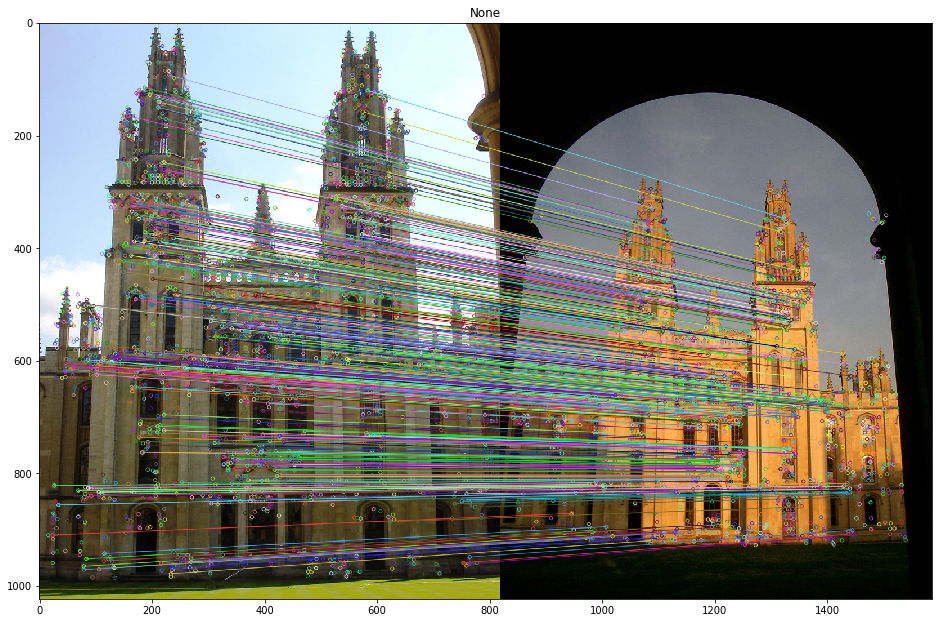

1200

In [46]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline



def parse_sift_output(target_path):
    """
    Return:
        kp: keypoint of hessian affine descriptor. location, orientation etc... OpenCV KeyPoint format. 
        des: 128d uint8 np array
    """
    import os
    # print(os.listdir("./sample"))
    kp = []
    des = []
    with open(target_path, "r") as f:
        lines = list(map(lambda x: x.strip(), f.readlines()))
        num_descriptor = int(lines[1])
        lines = lines[2:]
        for i in range(num_descriptor):
            # print(i, lines[i])
            val = lines[i].split(" ")
            x = float(val[0])
            y = float(val[1])
            a = float(val[2])
            b = float(val[3])
            c = float(val[4])
            # TODO: generate ellipse shaped key point
            # Refer: https://math.stackexchange.com/questions/1447730/drawing-ellipse-from-eigenvalue-eigenvector
            # Refer: http://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/display_features.m
            # Refer: http://www.robots.ox.ac.uk/~vgg/research/affine/detectors.html
            key_point = cv2.KeyPoint(x, y, 1)
            sift_descriptor = np.array(list(map(lambda x: int(x), val[5:])), dtype=np.uint8)
            kp.append(key_point)
            des.append(sift_descriptor)
        
    
    return kp, np.array(des)

kp1, des1 = parse_sift_output(target_path="../sample/all_souls_000026.jpg.hesaff.sift")
kp2, des2 = parse_sift_output(target_path="../sample/all_souls_000055.jpg.hesaff.sift")


img1 = cv2.imread('../sample/all_souls_000026.jpg') # query image
img2 = cv2.imread('../sample/all_souls_000055.jpg')

_, num_inliner = ransac(img1, img2, kp1, kp2, des1, des2, False, 'BRUTE_FORCE', None)
print('num_inliner:', num_inliner)

# ransac and plot
draw_ransac(img1, img2, kp1, kp2, des1, des2, False, 'BRUTE_FORCE', None)
